# KL1d_figures_demo

To accompany the paper *Generating Random Earthquake Events for Probabilistic Tsunami Hazard Assessment*, by R. J. LeVeque, K. Waagan, F. I. Gonzlez, D. Rim, and G. Lin, http://arxiv.org/abs/1605.02863. 

This code and related files can be found in https://github.com/rjleveque/KLslip-paper.  See the README.md file for information on dependencies.

Contains essentially the same code as in the script `KL1d_figures.py` but with additional explanation.  Also more realizations are generated and displayed.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys, os
import dtopotools
import pandas as pd
from numpy import random
from ipywidgets import interact
import ipywidgets as widgets
from scipy import stats
import KDEplots  # code to plot joint and marginal densities

/Users/rjl/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### Utility function for displaying a list of figures with a slider bar:

In [3]:
def animate_figs(figs):
    interact(lambda n: display(figs[n]), \
             n=widgets.IntSlider(min=0,max=len(figs)-1, value=0))

In [4]:
# Only needed if saving figures, these lines are commented out in notebook.
subdir = 'figures'
os.system('mkdir -p %s' % subdir)

def savefigp(fname):
    fname = os.path.join(subdir,fname)
    savefig(fname, bbox_inches='tight')
    print "Created ",fname
    

### Specify parameters and compute the correlation matrix

In [5]:
# Parameters to adjust...
dip = 13.     # dip angle in degrees
depth0 = 10e3  # depth of top of fault in meters

W = 100e3  # width of fault plane (down-dip) in meters
x = linspace(0,W,201)  # meters
x = x[:-1]  # drop last point so x values are top of subfaults
xkm = x / 1e3  # km for plotting

xkm_shore = 75

ndip = len(x)
m = ndip # dimension of matrices


cdip_fraction = 0.4  # correlation length
cdip = cdip_fraction*W  # correlation length in dip

mean_slip = 10. # desired average slip (meters)
L = 1000e3  # length of fault to use in computing deformation (very long)

rigidity = 3.55e10
Mo = L*W*mean_slip * rigidity
Mw = 2./3. * (log10(Mo) - 9.05)
print "mean magnitude Mw = %5.2f" % Mw

# Rigidity was calculated via:
#Mw_desired = 9.0
#Mo_desired = 10.**(1.5*Mw_desired + 9.05)
#rigidity = Mo_desired / (L*W*mean_slip)

def corr(x1,x2):
    c = exp(-abs(x1-x2)/cdip)  # exponential
    #c = exp(-((x1-x2)/cdip)**2) # Gaussian
    return c

# Correlation matrix with no sigma's:
Chat = eye(m)
for i in range(m):
    for j in range(m):
        Chat[i,j] = corr(x[i],x[j])

mean magnitude Mw =  9.00


### Define a taper:

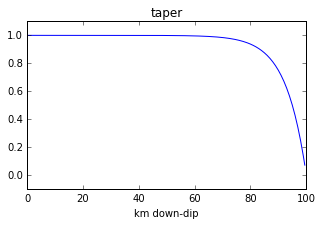

In [6]:
taper = 'exp_depth'

if taper=='none':
    tau = lambda x: ones(x.shape)

elif taper=='cospower':
    power = 10     # used in taper tau
    tau = lambda x: 1. - (1. - 0.5*(1. + cos(2*pi*(x+0.5*W)/W)))**power

elif taper=='cospower_downdip':
    power = 10     # used in taper tau
    tau = lambda x: where(x<W/2, 1., 1. - (1. - 0.5*(1. + cos(2*pi*(x+0.5*W)/W)))**power)
        
    
elif taper=='WangHe':
    # Wang and He (2008) taper:
    broadness = 0.25  #0.25
    qskew = 0.65
    def delta(xp):
        d1 = (12./qskew**3) * xp**2 * (qskew/2. - xp/3.)
        #d2 = (12./(1.-qskew)**3) * xp**2 * ((1.-qskew)/2. - (1.-xp)/3.)
        #d = where(xp <= qskew, d1, d2)
        dq = 2. 
        d2 = dq + (12./(1.-qskew)**3) * \
              ((xp**3 / 3. - xp**2 *(1+qskew)/2. + qskew*xp) \
             - (qskew**3 / 3. - qskew**2*(1+qskew)/2. + qskew**2))
        d = where(xp <= qskew, d1, d2)
        #import pdb; pdb.set_trace()
        return d
    def tau(x):
        xp = (x-x[0])/(x[-1]-x[0])
        #import pdb; pdb.set_trace()
        return delta(xp) * (1. + sin(broadness * pi * delta(xp)))

elif taper=='exp_depth':
    max_depth = 32500.
    tau_depth = lambda d: 1. - exp((d - max_depth)*20/max_depth)
    tau = lambda x: tau_depth(depth0 + x*sin(dip*pi/180.))


figure(figsize=(5,3))
plot(xkm, tau(x))
xlabel('km down-dip')
title('taper')
ylim(-0.1,1.1);
show()

### Compute Covariance matrix and eigen-decomposition

Max imaginary part of lam:  0.0


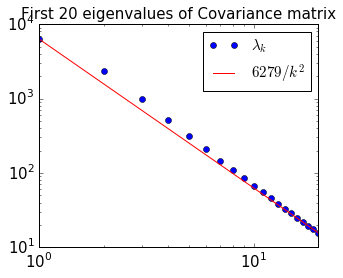

In [7]:
total_slip = mean_slip * len(x)
mu = total_slip * tau(x) / sum(tau(x)) # mean slip with taper

alpha = 0.75
sigma = alpha * mu
S = diag(sigma)
C = dot(dot(S,Chat),S)

lam, V = eig(C)
# C is symmetric so eigenvalues should be real
print "Max imaginary part of lam: ",abs(imag(lam)).max()
lam = real(lam)
V = real(V)

# Normalize eigenvectors to have 2-norm = 1:
# Should be normalized already!
for k in range(m):
    V[:,k] = V[:,k] / norm(V[:,k],2)

# Negate modes if necessary to facilitate comparisons:
# Choose sign so they all are initially increasing...
for k in range(m):
    if V[10,k] < 0:
        V[:,k] = -V[:,k]

# Sort eigenvalues:
i = list(argsort(lam))
i.reverse()
lam = lam[i]
V = V[:,i]

kplot=20
figure(figsize=(5,4))
loglog(range(1,kplot+1),lam[:kplot], 'o',label='$\lambda_k$')
k = linspace(1,kplot,kplot)
numer = int(round(lam[0]))

plot(k,numer/k**2,'r',label='$%i/k^2$' % numer)
legend(fontsize=15)
xticks(fontsize=15); yticks(fontsize=15);
xlim(1,20);
title("First %i eigenvalues of Covariance matrix" % kplot, fontsize=15);
#savefigp('eigenvalues.jpg')
show()

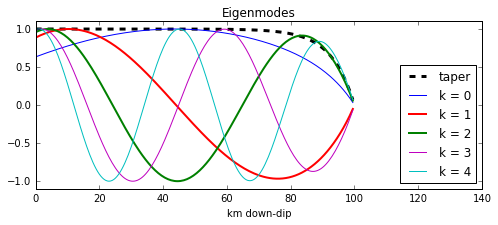

In [8]:
figure(figsize=(8,3))
plot(xkm,tau(x), 'k--', label='taper',linewidth=3)
plot(xkm,V[:,0]/max(V[:,0]),'b',label='k = 0')
plot(xkm,V[:,1]/max(V[:,1]),'r',linewidth=2,label='k = 1')
plot(xkm,V[:,2]/max(V[:,2]),'g',linewidth=2,label='k = 2')
plot(xkm,V[:,3]/max(V[:,3]),'m',linewidth=1,label='k = 3')
plot(xkm,V[:,4]/max(V[:,4]),'c',linewidth=1,label='k = 4')
legend(loc='lower right')
xlim(0,140)
ylim(-1.1,1.1)
xlabel('km down-dip')
title('Eigenmodes')

### Apply Okada to each eigenvector:

In [9]:
# Replace first eigenvector by mean:
V[:,0] = mu

#input_units = {'slip': 'm', 'depth': 'km', 'length': 'km', 'width': 'km'}
coordinate_specification = "top center"

# subfault parameters for full fault width:
subfault = dtopotools.SubFault()
subfault.coordinate_specification = coordinate_specification
subfault.longitude = 0.
subfault.latitude = 0.
subfault.depth = depth0
subfault.strike = 0.
subfault.length = 1000.e3  # very long since we want 1d cross section
subfault.width = W
subfault.dip = dip
subfault.rake = 90.
subfault.slip = 1.  # will be reset for each realization

# split up into fault with ndip subfaults
#base_fault = dtopotools.Fault([subfault], input_units, coordinate_specification) # needed to set units
fault = dtopotools.SubdividedPlaneFault(subfault, nstrike=1, ndip=ndip)

# grid on which to compute deformation:
n_dtopo = 1001  
x_dtopo = linspace(-2,2,n_dtopo)
xkm_dtopo = x_dtopo * 111.  # convert from degrees to km
y_dtopo = array([-1,0.,1.])  # for 1d slice

nterms = 20
dZ = zeros((n_dtopo,nterms+1)) # to store sea floor deformation corresponding to each mode V[:,j]

for j in range(nterms+1):
    for k,s in enumerate(fault.subfaults):
        s.slip = V[k,j]

    dtopo = fault.create_dtopography(x_dtopo,y_dtopo,times=[1.], verbose=False)
    print "Applying Okada to V[:,%i] to compute dZ[:,%i]" % (j,j)
    dZ[:,j] = dtopo.dZ[0,1,:]

    

Applying Okada to V[:,0] to compute dZ[:,0]
Applying Okada to V[:,1] to compute dZ[:,1]
Applying Okada to V[:,2] to compute dZ[:,2]
Applying Okada to V[:,3] to compute dZ[:,3]
Applying Okada to V[:,4] to compute dZ[:,4]
Applying Okada to V[:,5] to compute dZ[:,5]
Applying Okada to V[:,6] to compute dZ[:,6]
Applying Okada to V[:,7] to compute dZ[:,7]
Applying Okada to V[:,8] to compute dZ[:,8]
Applying Okada to V[:,9] to compute dZ[:,9]
Applying Okada to V[:,10] to compute dZ[:,10]
Applying Okada to V[:,11] to compute dZ[:,11]
Applying Okada to V[:,12] to compute dZ[:,12]
Applying Okada to V[:,13] to compute dZ[:,13]
Applying Okada to V[:,14] to compute dZ[:,14]
Applying Okada to V[:,15] to compute dZ[:,15]
Applying Okada to V[:,16] to compute dZ[:,16]
Applying Okada to V[:,17] to compute dZ[:,17]
Applying Okada to V[:,18] to compute dZ[:,18]
Applying Okada to V[:,19] to compute dZ[:,19]
Applying Okada to V[:,20] to compute dZ[:,20]


## Function to compute KL expansion:

In [10]:
def KL(z):
    """
    z = vector of coefficients.
    z[0] is ignored.
    """
    slip = mu 
    for k in range(1,len(z)):
        slip = slip + z[k]*sqrt(lam[k])*V[:,k]
    
    z_dtopo = dZ[:,0].copy()
    for k in range(1,len(z)):
        z_dtopo += z[k]*sqrt(lam[k])*dZ[:,k]
    z_dtopo = z_dtopo
    return slip, z_dtopo
        

### Plot mean slip and resulting deformation:

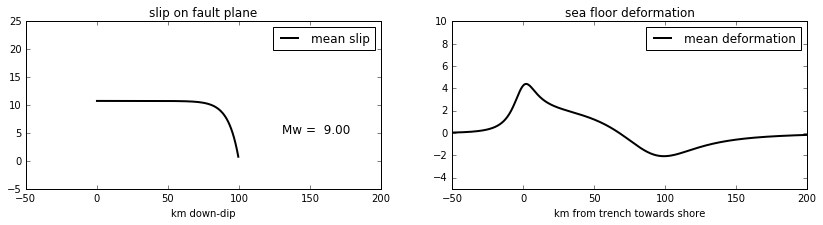

In [11]:
figure(figsize=(14,3))
subplot(121)
slip = mu
plot(xkm, slip, 'k', lw=2,label="mean slip")
legend(fontsize=12)
#plot(xkm,mu,'g')
ylim(-5,25)

Mo = L*W*sum(abs(slip))/len(slip) * rigidity
Mw = 2./3. * (log10(Mo) - 9.05)
text(130,5,"Mw = %5.2f" % Mw, fontsize=12, color='k')
xlim(-50,200)
xlabel('km down-dip')
title('slip on fault plane')

subplot(122)
z_dtopo = V[:,0]
plot(xkm_dtopo, dZ[:,0], 'k', lw=2,label="mean deformation")
legend(fontsize=12)
xlim(-50,200)
ylim(-5,10)
xlabel('km from trench towards shore')
title('sea floor deformation')
#savefigp('sample_realization_00.jpg')
show()

## Generate and plot random realizations

- Change the seed to generate a different set.
- Change `nterms` to use a different number of terms in K-L series.
- Change `nreal` to change the number of realizations to display.

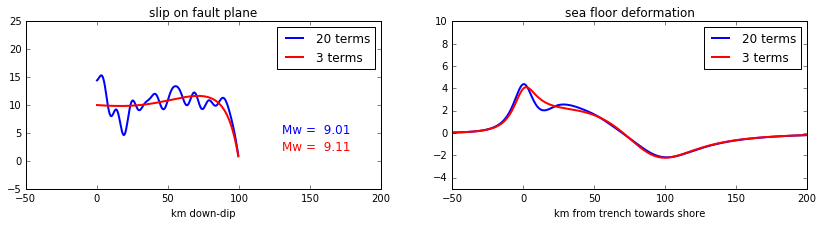

In [12]:
random.seed(12333)

nterms = 20
nreal = 30
figs = []  # to accumulate figures
for rno in range(nreal):
    z = randn(nterms+1)
    slip, z_dtopo = KL(z)

    nterms3 = 3
    slip3, z_dtopo3 = KL(z[:nterms3])

    fig = figure(figsize=(14,3))
    figs.append(fig)  # accumulate figures 
    
    subplot(121)
    plot(xkm,slip, 'b', lw=2,label="%i terms" % nterms)
    plot(xkm,slip3,'r', lw=2,label="%i terms" % nterms3)
    legend(fontsize=12)
    #plot(xkm,mu,'g')
    ylim(-5,25)

    Mo = L*W*sum(abs(slip))/len(slip) * rigidity
    Mw = 2./3. * (log10(Mo) - 9.05)
    text(130,5,"Mw = %5.2f" % Mw, fontsize=12, color='b')
    Mo = L*W*sum(abs(slip[:nterms3]))/len(slip[:nterms3]) * rigidity
    Mw = 2./3. * (log10(Mo) - 9.05)
    text(130,2,"Mw = %5.2f" % Mw, fontsize=12, color='r')

    xlim(-50,200)
    xlabel('km down-dip')
    title('slip on fault plane')

    subplot(122)
    plot(xkm_dtopo, z_dtopo, 'b', lw=2, label="%i terms" % nterms)
    plot(xkm_dtopo, z_dtopo3, 'r', lw=2,label="%i terms" % nterms3)
    #plot(xkm_dtopo, z_dtopo - z_dtopo3, 'g')
    legend(fontsize=12)
    #plot(xkm_dtopo, dZ[:,0], 'g')
    xlim(-50,200)
    ylim(-5,10)
    xlabel('km from trench towards shore')
    title('sea floor deformation')
    close(fig)
    
animate_figs(figs)

## Compute and plot various statistics

with xkm_shore = 75, the shore is at j = 668 in the dtopo.dZ arrays of length 1001
dZ at the shore for the mean slip is -0.614133
sigma =  0.511248834609
sigma =  0.921840652215
sigma =  1.00700525789
sigma =  1.01596994065


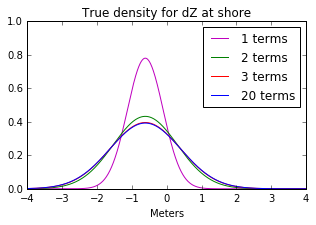

In [13]:
j_shore = find(xkm_dtopo < xkm_shore).max()
print "with xkm_shore = %g, the shore is at j = %i in the dtopo.dZ arrays of length %i" \
        % (xkm_shore, j_shore, dZ.shape[0])
dZ_shore_mean = dZ[j_shore,0]
print "dZ at the shore for the mean slip is %g" % dZ_shore_mean
b = dZ[j_shore,:] * sqrt(lam[:dZ.shape[1]])
#print "dZ at shore for any z is then %g + b^Tz where z[0]=0 and " % dZ[j_shore,0]
#print "   b = ",b

def normal_density(x, mean=0, variance=1):
    sigma = sqrt(variance)
    print "sigma = ",sigma
    return 1./(sigma*sqrt(2*pi)) * exp(-(x-mean)**2 / (2*variance))
dzs = linspace(-5,5,1001)

dzs_rho1 = normal_density(dzs, dZ_shore_mean, sum(b[1:2]**2))
dzs_rho2 = normal_density(dzs, dZ_shore_mean, sum(b[1:3]**2))
dzs_rho3 = normal_density(dzs, dZ_shore_mean, sum(b[1:4]**2))
dzs_rho20 = normal_density(dzs, dZ_shore_mean, sum(b[1:21]**2))

figure(figsize=(5,3))
plot(dzs, dzs_rho1, 'm', label='1 terms')
plot(dzs, dzs_rho2, 'g', label='2 terms')
plot(dzs, dzs_rho3, 'r', label='3 terms')
plot(dzs, dzs_rho20, 'b', label='20 terms')

xlim(-4,4)
ylim(0,1)
legend()
xlabel('Meters')
title("True density for dZ at shore")
#savefigp("DBshore-true.jpg")
show()

In [14]:
def test(ntrials = 10000, nterms=10, xkm_shore=300):
    grav = 9.81 # m/s**2
    rho_water = 1000.   # kg/m**3
    dx = x[1] - x[0]  # for integrating potential energy
    Energy = zeros(ntrials)
    Amplitude = zeros(ntrials)
    z_shore = zeros(ntrials)
    EtaMax = zeros(ntrials)
    
    scorr = zeros(V[:,0].shape)
    zvals = zeros((ntrials,nterms+1))
    for j in range(ntrials):
        z = randn(nterms+1)  # choose random z for this realization
        zvals[j,:] = z
        slip, z_dtopo = KL(z)
        scorr += (slip[50] - mu[50])*(slip - mu) / (sigma[50]*sigma)
        z_offshore = where(xkm_dtopo < xkm_shore, z_dtopo, 0.)
        Energy[j] = sum(z_offshore**2) * grav * rho_water * \
            dx*L * 1e-15  # PetaJoules
        Amplitude[j] = z_offshore.max() - z_offshore.min()
        z_shore[j] = z_dtopo[j_shore]  # uplift or subsidence at shoreline
        EtaMax[j] = z_offshore.max()
    return Energy, Amplitude, z_shore, EtaMax, zvals

### Generate 20,000 samples with 20-term series

This cell takes a few seconds to execute...

In [15]:
xkm_shore = 75
random.seed(12345)
ntrials = 20000
print "Generating %s samples..." % ntrials
Energy, Amplitude, z_shore, EtaMax, zvals = test(ntrials = ntrials, nterms=20, xkm_shore=xkm_shore)

Generating 20000 samples...


Do the same for 1-term, 2-term, and 3-terms series:

In [16]:
DepthProxy = EtaMax - z_shore
realizations = pd.DataFrame()
realizations['Energy'] = Energy
realizations['Amplitude'] = Amplitude
realizations['subsidence / uplift'] = z_shore
realizations['EtaMax'] = EtaMax
realizations['depth proxy'] = DepthProxy


random.seed(12345)
ntrials = 20000
print "Generating %s samples..." % ntrials
Energy1, Amplitude1, z_shore1, EtaMax1, zvals1 = test(ntrials = ntrials, nterms=1, xkm_shore=xkm_shore)
realizations1 = pd.DataFrame()
realizations1['Energy'] = Energy1
realizations1['Amplitude'] = Amplitude1
realizations1['subsidence / uplift'] = z_shore1
realizations1['EtaMax'] = EtaMax1
DepthProxy1 = EtaMax1 - z_shore1
realizations1['depth proxy'] = DepthProxy1


random.seed(12345)
ntrials = 20000
print "Generating %s samples..." % ntrials
Energy2, Amplitude2, z_shore2, EtaMax2, zvals2 = test(ntrials = ntrials, nterms=2, xkm_shore=xkm_shore)
realizations2 = pd.DataFrame()
realizations2['Energy'] = Energy2
realizations2['Amplitude'] = Amplitude2
realizations2['subsidence / uplift'] = z_shore2
realizations2['EtaMax'] = EtaMax2
DepthProxy2 = EtaMax2 - z_shore2
realizations2['depth proxy'] = DepthProxy2


random.seed(12345)
ntrials = 20000
print "Generating %s samples..." % ntrials
Energy3, Amplitude3, z_shore3, EtaMax3, zvals3 = test(ntrials = ntrials, nterms=3, xkm_shore=xkm_shore)
realizations3 = pd.DataFrame()
realizations3['Energy'] = Energy3
realizations3['Amplitude'] = Amplitude3
realizations3['subsidence / uplift'] = z_shore3
realizations3['EtaMax'] = EtaMax3
DepthProxy3 = EtaMax3 - z_shore3
realizations3['depth proxy'] = DepthProxy3

Generating 20000 samples...
Generating 20000 samples...
Generating 20000 samples...


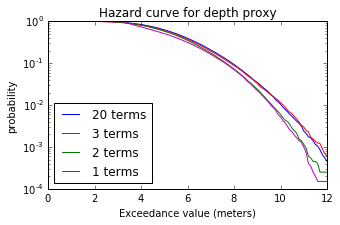

In [17]:
def hazard_curve(realizations, zetai):
    counts = zeros(zetai.shape)
    for j in range(len(zetai)):
        i = realizations['depth proxy'] > zetai[j]
        counts[j] = sum(i)
    prob = counts / len(realizations)

    return prob

zetai = linspace(0,12,121)
prob = hazard_curve(realizations, zetai)
prob3 = hazard_curve(realizations3, zetai)
prob2 = hazard_curve(realizations2, zetai)
prob1 = hazard_curve(realizations1, zetai)
figure(figsize=(5,3))
semilogy(zetai, prob, 'b', label='20 terms')
semilogy(zetai, prob3, 'r', label='3 terms')
semilogy(zetai, prob2, 'g', label='2 terms')
semilogy(zetai, prob1, 'm', label='1 terms')
legend(loc='lower left')
title('Hazard curve for depth proxy')
xlabel('Exceedance value (meters)')
ylabel('probability')
#savefigp('hazcurves1.jpg')
show()

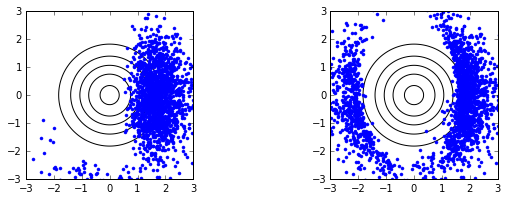

In [18]:
def plot_gaussian_contours():
    z1 = linspace(-3, 3, 100)
    Z1,Z2 = meshgrid(z1,z1)
    G = 1./(2*pi) * exp(-(Z1**2 + Z2**2)/2.)
    contour(Z1,Z2,G,5, colors='k')
    axis('scaled')

figure(figsize=(10,3))
subplot(121)
j = DepthProxy3 > 8
plot_gaussian_contours()
plot(zvals3[j,1],zvals3[j,2],'.')
#savefigp('z12_bigdepth.jpg')

subplot(122)
j = Energy3 > 9.5
plot_gaussian_contours()
plot(zvals3[j,1],zvals3[j,2],'.')
#savefigp('z12_bigenergy.jpg')

## Kernel density estimates (KDE)

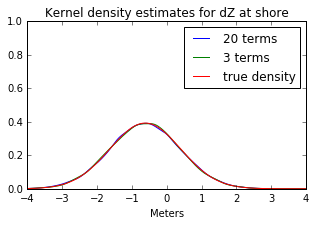

In [19]:

kde = stats.gaussian_kde(realizations['subsidence / uplift'])
rho = kde.pdf(dzs)

kde3 = stats.gaussian_kde(realizations3['subsidence / uplift'])
rho3 = kde3.pdf(dzs)

figure(figsize=(5,3))
ax = axes()
plot(dzs,rho,label='20 terms')
plot(dzs,rho3,label='3 terms')
plot(dzs, dzs_rho20, 'r', label='true density')
legend()
xlim(-4,4)
ylim(0,1.0)
title("Kernel density estimates for dZ at shore")
xlabel('Meters')
#savefigp('DBshore-samples.jpg')

In [20]:
Q1 = 'EtaMax'
Q2 = 'Energy'

Nx = 200
Ny = 201

x0 = 2.
x1 = 9.

y0 = 4.
y1 = 11.

x = np.linspace(x0,x1,Nx)
y = np.linspace(y0,y1,Ny)

X,Y = np.meshgrid(x,y)

xy = np.vstack((X.flatten(),Y.flatten()))

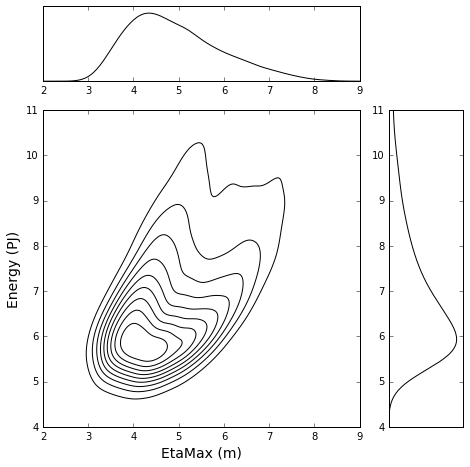

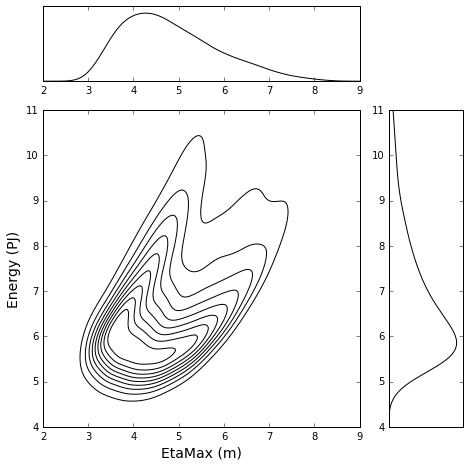

In [21]:
# 20 terms:
rvals = vstack((realizations[Q1].T, realizations[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))
fig = KDEplots.joint_plot(X,Y,rho,xname='EtaMax (m)',yname='Energy (PJ)')

# 3 terms:
rvals = vstack((realizations3[Q1].T, realizations3[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))
fig = KDEplots.joint_plot(X,Y,rho,xname='EtaMax (m)',yname='Energy (PJ)')

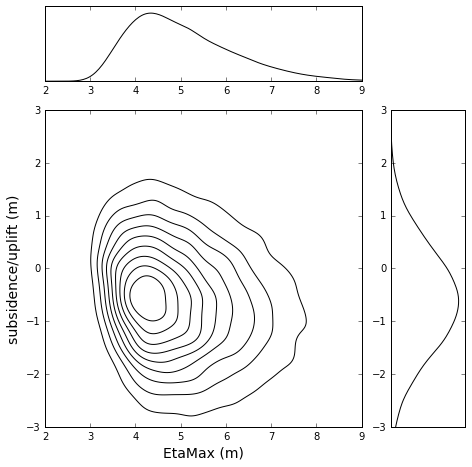

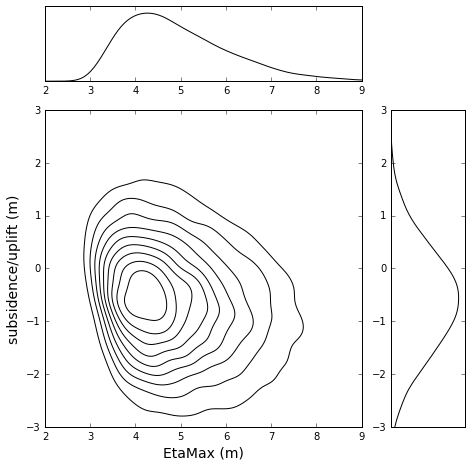

In [22]:
Q1 = 'EtaMax'
Q2 = 'subsidence / uplift'

Nx = 200
Ny = 201

x0 = 2.
x1 = 9.

y0 = -3.
y1 = 3.

x = np.linspace(x0,x1,Nx)
y = np.linspace(y0,y1,Ny)

X,Y = np.meshgrid(x,y)

xy = np.vstack((X.flatten(),Y.flatten()))

# 20 terms:
rvals = vstack((realizations[Q1].T, realizations[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))
fig = KDEplots.joint_plot(X,Y,rho,xname='EtaMax (m)',yname='subsidence/uplift (m)')

# 3 terms:
rvals = vstack((realizations3[Q1].T, realizations3[Q2].T))
kde = stats.gaussian_kde(rvals)
p = kde.pdf(xy) * (x1-x0)*(y1-y0)/float(Nx*Ny)
rho = reshape(p,(Ny,Nx))
fig = KDEplots.joint_plot(X,Y,rho,xname='EtaMax (m)',yname='subsidence/uplift (m)')

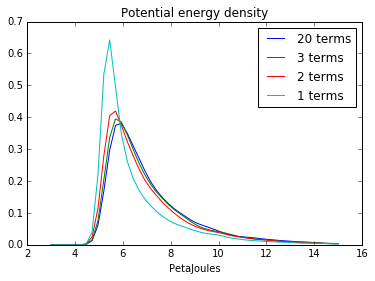

In [29]:
E = linspace(3,15)
kde = stats.gaussian_kde(realizations['Energy'])
rho = kde.pdf(E)
plot(E, rho, label='20 terms')

kde = stats.gaussian_kde(realizations3['Energy'])
rho = kde.pdf(E)
plot(E, rho, label='3 terms')

kde = stats.gaussian_kde(realizations2['Energy'])
rho = kde.pdf(E)
plot(E, rho, label='2 terms')

kde = stats.gaussian_kde(realizations1['Energy'])
rho = kde.pdf(E)
plot(E, rho, label='1 terms')

legend()
xlabel('PetaJoules')
title('Potential energy density')
#savefigp('kde_Energy.jpg')


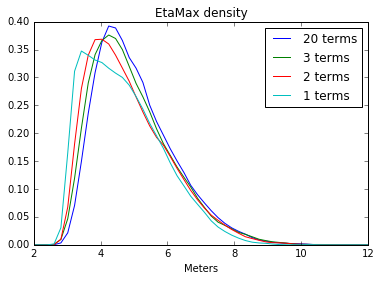

In [28]:
E = linspace(2,12)
kde = stats.gaussian_kde(realizations['EtaMax'])
rho = kde.pdf(E)
plot(E, rho, label='20 terms')

kde = stats.gaussian_kde(realizations3['EtaMax'])
rho = kde.pdf(E)
plot(E, rho, label='3 terms')

kde = stats.gaussian_kde(realizations2['EtaMax'])
rho = kde.pdf(E)
plot(E, rho, label='2 terms')

kde = stats.gaussian_kde(realizations1['EtaMax'])
rho = kde.pdf(E)
plot(E, rho, label='1 terms')

legend()
xlabel('Meters')
title('EtaMax density')
#savefigp('kde_EtaMax.jpg')
